In [1]:
from mpl_toolkits.mplot3d import Axes3D
import os
import pandas as pd
import numpy as np

from math import ceil 
from skimage import io
from skimage import filters, color
from scipy import ndimage as ndi
from PIL import Image
import cv2
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

import processing as proc
import processing_new as newproc

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
!ls saved_models
models = os.popen("ls saved_models").read().split('\n')[:-1]
tf_model = keras.models.load_model('saved_models/'+models[-1])

mnist_5epochs_20191028.h5  mnist_hasyv2_20epochs_201910291572394063.h5


In [3]:
imgs = os.popen("ls testmarker").read().split('\n')[:-1]
for i,img in enumerate(imgs):
    imgs[i]='testmarker/'+img
imgs
# imgs = os.popen("ls generated_imageset").read().split('\n')[:-1]
# for i,img in enumerate(imgs):
#     imgs[i]='generated_imageset/'+img
# imgs

['testmarker/068479.jpg',
 'testmarker/10645.jpg',
 'testmarker/10897649.jpg',
 'testmarker/16786.jpg',
 'testmarker/17662814.jpg',
 'testmarker/2185.jpg',
 'testmarker/22069.jpg',
 'testmarker/22765.jpg',
 'testmarker/236951.jpg',
 'testmarker/26635409.jpg',
 'testmarker/279134.jpg',
 'testmarker/32128957.jpg',
 'testmarker/39385210.jpg',
 'testmarker/46320745.jpg',
 'testmarker/50473.jpg',
 'testmarker/648502.jpg',
 'testmarker/657213.jpg',
 'testmarker/66682.jpg',
 'testmarker/731984.jpg',
 'testmarker/74036776.jpg',
 'testmarker/74430.jpg',
 'testmarker/7493.jpg',
 'testmarker/81064327.jpg',
 'testmarker/84843617.jpg',
 'testmarker/97765113.jpg']

In [4]:
labels = []
for filename in imgs:
    label = []
    for digit in filename.split('/')[1][:-4]:
#         print(digit)
        label.append(int(digit))
    labels.append(label)
labels

[[0, 6, 8, 4, 7, 9],
 [1, 0, 6, 4, 5],
 [1, 0, 8, 9, 7, 6, 4, 9],
 [1, 6, 7, 8, 6],
 [1, 7, 6, 6, 2, 8, 1, 4],
 [2, 1, 8, 5],
 [2, 2, 0, 6, 9],
 [2, 2, 7, 6, 5],
 [2, 3, 6, 9, 5, 1],
 [2, 6, 6, 3, 5, 4, 0, 9],
 [2, 7, 9, 1, 3, 4],
 [3, 2, 1, 2, 8, 9, 5, 7],
 [3, 9, 3, 8, 5, 2, 1, 0],
 [4, 6, 3, 2, 0, 7, 4, 5],
 [5, 0, 4, 7, 3],
 [6, 4, 8, 5, 0, 2],
 [6, 5, 7, 2, 1, 3],
 [6, 6, 6, 8, 2],
 [7, 3, 1, 9, 8, 4],
 [7, 4, 0, 3, 6, 7, 7, 6],
 [7, 4, 4, 3, 0],
 [7, 4, 9, 3],
 [8, 1, 0, 6, 4, 3, 2, 7],
 [8, 4, 8, 4, 3, 6, 1, 7],
 [9, 7, 7, 6, 5, 1, 1, 3]]

In [5]:
df = pd.DataFrame(imgs)
df.columns = ['filename']
df['label'] = labels
# df.to_csv('prepared_labels.csv',index=False)

In [6]:
# prepared = df.as_matrix()
df_subset = df.copy()     #.iloc[:1000]
df_subset

,filename,label
0,testmarker/068479.jpg,"[0, 6, 8, 4, 7, 9]"
1,testmarker/10645.jpg,"[1, 0, 6, 4, 5]"
2,testmarker/10897649.jpg,"[1, 0, 8, 9, 7, 6, 4, 9]"
3,testmarker/16786.jpg,"[1, 6, 7, 8, 6]"
4,testmarker/17662814.jpg,"[1, 7, 6, 6, 2, 8, 1, 4]"
5,testmarker/2185.jpg,"[2, 1, 8, 5]"
6,testmarker/22069.jpg,"[2, 2, 0, 6, 9]"
7,testmarker/22765.jpg,"[2, 2, 7, 6, 5]"
8,testmarker/236951.jpg,"[2, 3, 6, 9, 5, 1]"
9,testmarker/26635409.jpg,"[2, 6, 6, 3, 5, 4, 0, 9]"


In [15]:
img = cv2.imread('images/0734_segmented.png')
r,g,b= cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()

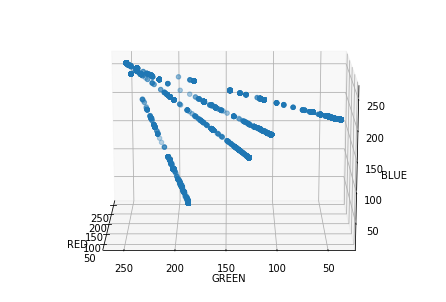

In [22]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
ax.set_xlabel('RED')
ax.set_ylabel('GREEN')
ax.set_zlabel('BLUE')
ax.view_init(15,180)
plt.show()

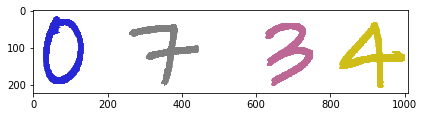

In [17]:
io.imshow(img)

In [40]:
# img = cv2.imread(imgs[0])
img = cv2.imread('images/0734_segmented.png')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 4, 1.0)

In [43]:
K = 10
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

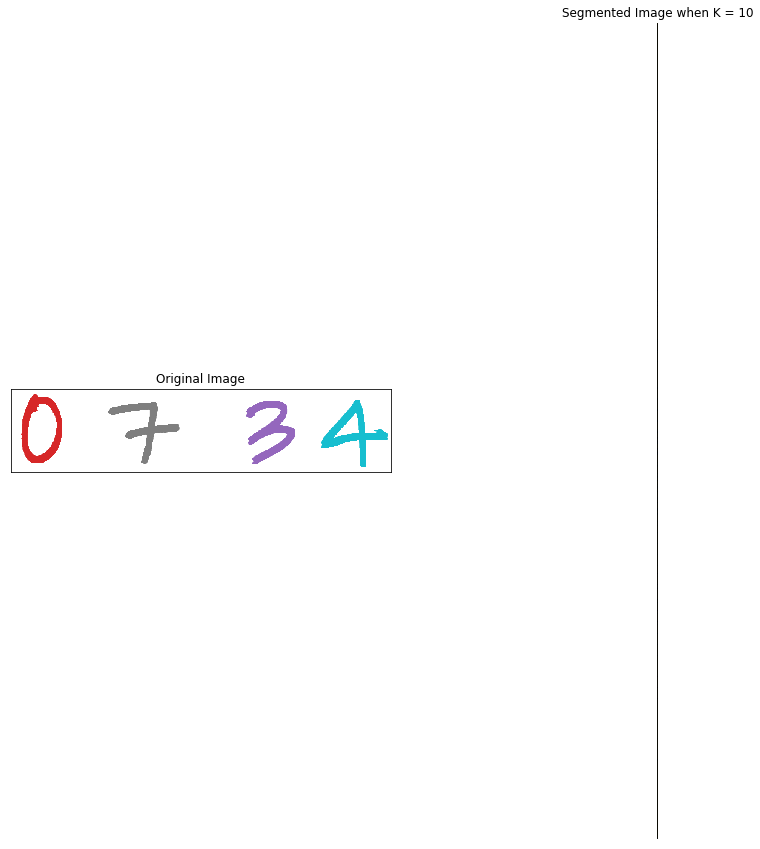

In [44]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

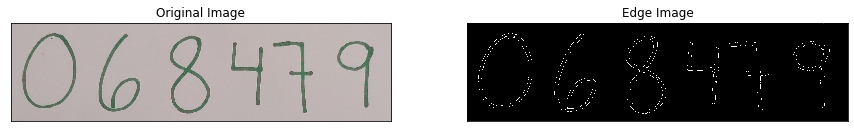

In [39]:
edges = cv2.Canny(img,110,150)
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

1 of 25
processing  testmarker/068479.jpg
[0, 6, 8, 4, 7, 9]; [0, 0, 6, 3, 4, 5, 7]

2 of 25
processing  testmarker/10645.jpg
[1, 0, 6, 4, 5]; [1, 0, 6, 4, 5, 6]

3 of 25
processing  testmarker/10897649.jpg
[1, 0, 8, 9, 7, 6, 4, 9]; [1, 0, 8, 9, 9, 6, 4, 9]

4 of 25
processing  testmarker/16786.jpg


KeyboardInterrupt: 

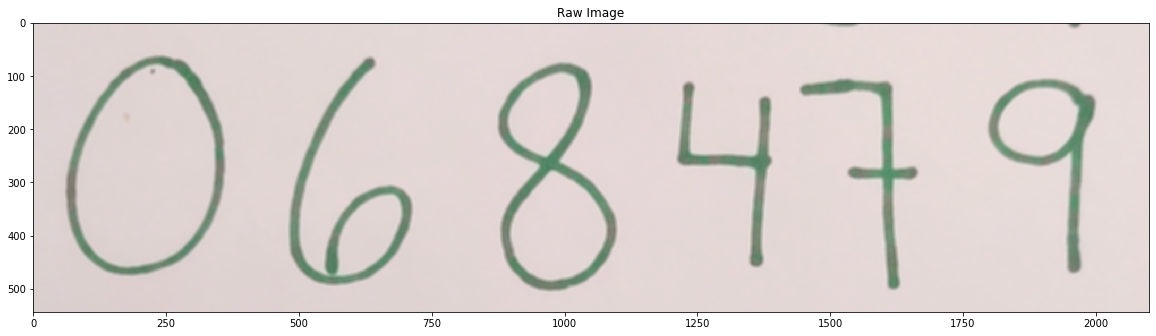

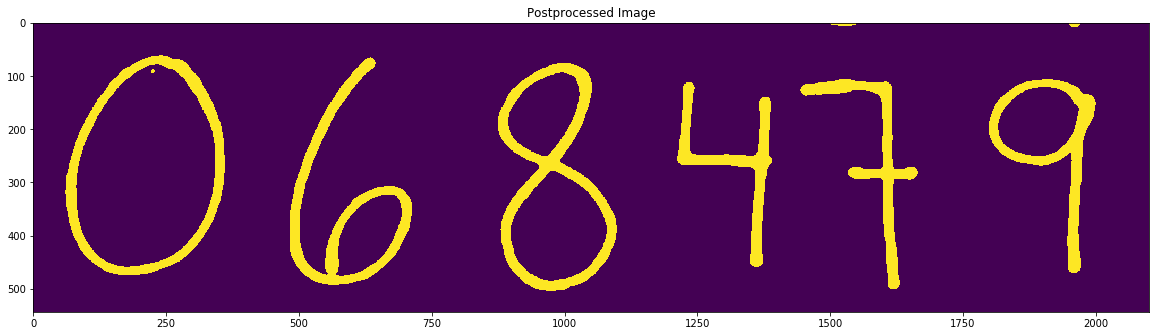

Error in callback <function flush_figures at 0x7f5774317510> (for post_execute):


KeyboardInterrupt: 

In [7]:
# predictions = []
# with open('test_new_model__subset.txt','w') as writeFile:
#     for index,image in enumerate(df_subset['filename']):
#         matname = 'tf22_marker/HANDWRITING__'+image[-8:-4]
#         print(index+1,'of',len(df_subset))
#         print('processing ',image)
#         binary_arr,label_arr, segments,orig = proc.label_segments(image,matname,photo=True,marker=False)
        
#         predicted = []
#         fig,axes = plt.subplots(len(segments),figsize=(6,6*len(segments)))
#         for seg,ax in list(zip(segments,axes.flatten())):
#             found = label_arr==seg
#             x,y = np.where(found)
#             xmin,xmax,ymin,ymax = np.min(x),np.max(x),np.min(y),np.max(y)
#             xlen,ylen = found[xmin:xmax,ymin:ymax].shape
#             diff = np.abs(ylen-xlen)
#             change = ceil(diff/2)
#             if diff!=0:
#                 if ylen>xlen:
#                     xmin-=change
#                     xmax+=change

#                 else:
#                     ymin-=change
#                     ymax+=change

#                 xlen,ylen = xmax-xmin,ymax-ymin
#                 diff=np.abs(ylen-xlen)
#                 if xlen>ylen: ymax+=diff
#                 elif ylen>xlen: xmax+=diff
#             digit = binary_arr[xmin:xmax,ymin:ymax]
#             digit = np.pad(digit,int(len(digit)*.2),mode= 'constant', constant_values=(0,0))        
#             if digit.shape[0]<10:
#                 ax.set_visible(False)       
#                 pass
#             else:
#                 ax.imshow(digit,cmap='gray')
#                 im = Image.fromarray(np.array(digit)*255.0).convert("RGB")
#                 im.save('000.jpg')
#                 img = cv2.resize(cv2.imread('000.jpg',cv2.IMREAD_GRAYSCALE),(28,28),interpolation=cv2.INTER_CUBIC)
#                 !rm 000.jpg
#                 p = np.argmax(tf_model.predict(img.astype(float).flatten().reshape((1, 28, 28, 1))))
#                 ax.set_title(p)
#                 im.save(matname+'___predicted____'+str(p)+'.jpg')
#                 predicted.append([ymin,p])

#         predicted.sort()    
#         predicted = [pr[1] for pr in predicted]

#         row = str(df_subset.iloc[index]['label'])+'; '+str(list(predicted))+'\n'
#         print(row)
#         writeFile.write(row)
#         predictions.append(predicted)
# writeFile.close()


In [ ]:
df_subset['predict'] = predictions
df_subset

In [57]:
df_subset['compare']= df_subset.label==df_subset.predict
df_subset['compare_sets']= [set(x)==set(y) for x,y in list(zip(df_subset.label,df_subset.predict))]
df_subset.compare.value_counts()

False    13
True     12
Name: compare, dtype: int64

In [59]:
# df_subset

In [25]:
# a = labels[-1]
# b = predictions[-1]

In [63]:
def score_prediction(a1,b1):
    a=a1.copy()
    b=b1.copy()
    print(a,b)
    mishape=False
    if len(a)!=len(b):
        mishape=True
    over = len(a)
    score = 0

    for i in range(len(a)):
        print(a,b)
        if a[i]==b[i]:
            score+=1
            continue
        elif mishape:
            b.remove(b[i])
            if len(a)==len(b):
                mishape=False
            if a[i]==b[i]:
                score+=1
            else:
                pass

#     print(score,' of ',over)
#     print(a)
#     print(b)
    return score/over

In [ ]:
df_subset['score'] = [score_prediction(a,b) for a,b in list(zip(df_subset['label'],df_subset['predict']))]

In [72]:
df_subset

,filename,label,predict,compare,score
0,testmarker/068479.jpg,"[0, 6, 8, 4, 7, 9]","[0, 0, 6, 3, 4, 5, 7]",False,0.500000
1,testmarker/10645.jpg,"[1, 0, 6, 4, 5]","[1, 0, 6, 4, 5, 6]",False,1.000000
2,testmarker/10897649.jpg,"[1, 0, 8, 9, 7, 6, 4, 9]","[1, 0, 8, 9, 9, 6, 4, 9]",False,0.875000
3,testmarker/16786.jpg,"[1, 6, 7, 8, 6]","[1, 6, 7, 8, 6]",True,1.000000
4,testmarker/17662814.jpg,"[1, 7, 6, 6, 2, 8, 1, 4]","[1, 7, 6, 6, 2, 8, 1, 4]",True,1.000000
5,testmarker/2185.jpg,"[2, 1, 8, 5]","[4, 4, 2, 4, 1, 8, 5]",False,0.500000
6,testmarker/22069.jpg,"[2, 2, 0, 6, 9]","[2, 0, 2, 0, 6, 9]",False,1.000000
7,testmarker/22765.jpg,"[2, 2, 7, 6, 5]","[2, 2, 7, 0, 6, 0, 5]",False,1.000000
8,testmarker/236951.jpg,"[2, 3, 6, 9, 5, 1]","[1, 3, 6, 9, 5, 1]",False,0.833333
9,testmarker/26635409.jpg,"[2, 6, 6, 3, 5, 4, 0, 9]","[2, 6, 6, 3, 5, 4, 0, 9]",True,1.000000


In [318]:
# predictions = []
# with open('test_new_model__subset.txt','w') as writeFile:
#     for index,image in enumerate(df_subset['filename'].iloc[1:]):
#         matname = 'tf22/HANDWRITING__'+image[-8:-4]
#         print(index+1,'of',len(df_subset))
#         print('processing ',image)
#         binary_arr,label_arr, segments,orig = proc.label_segments(image,matname,photo=True)
#         predicted = []
#         for seg in segments:
#             try:
#                 pred = proc.crop_image(seg,label_arr,orig,model=tf_model,direc=matname,svc=False,tf=True)[1]
#             except:
#                 pred = None
#             if pred!= None: predicted.append(pred)
#         predictions.append(predicted)
#         row = str(df_subset.iloc[index]['label'])+'; '+str(list(pred))+'\n'
#         print(row)
#         writeFile.write(row)
# writeFile.close()


In [305]:
# df_subset.to_csv('test_pred_tf3.csv',index=False)
predictions

[[], [], [], [], [], [], [], []]

Text(0.5, 1.0, 'Preprocessed Binary Image')

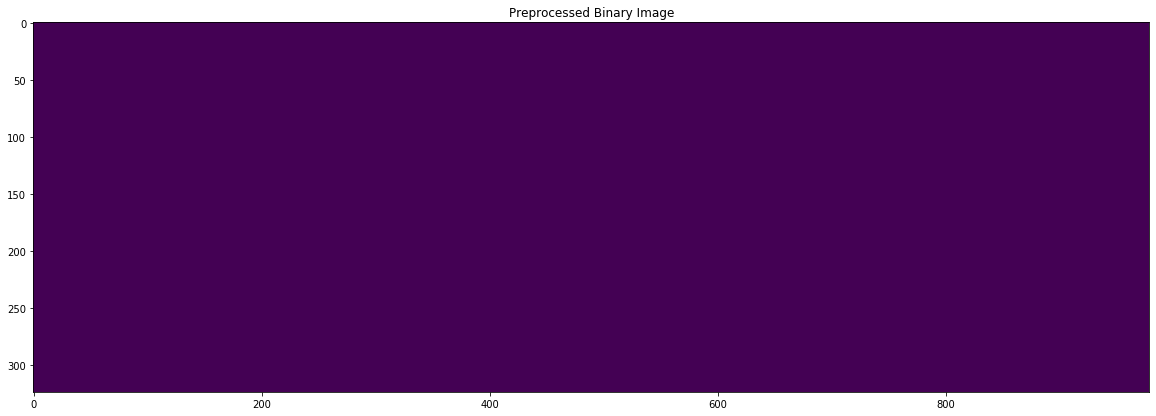

In [44]:
image = io.imread(imgs[0])
alpha=1.2
beta=0
marker = False
image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
if marker==False:
    image = cv2.blur(image, (8, 8))
arrraaayyy = np.array(image)
fig,axes = plt.subplots(1,figsize=(20,10))
label_arr, num_seg = ndi.label(color.rgb2gray(arrraaayyy))
axes.imshow(label_arr)
axes.set_title('Preprocessed Binary Image') 


In [31]:
def plot_numbered_image(label_arr,savename='',no_rotate=False):
    IMAGE = savename+'_segmented.jpg'
    pixarray=np.rot90(label_arr,3)
    imax,jmax = pixarray.shape
    fig,ax=plt.subplots(ncols=1, nrows=1, figsize=(20,int(20*jmax/imax)))
    plt.xticks(np.arange(0,imax))
    plt.yticks(np.arange(0,jmax))
    for i in range(0,imax,2):
        for j in range(0,jmax,2):
            val = pixarray[i][j]
            if val != 0:
                ax.scatter(i,j,s=300,color='k')
#                 ax.text(i,j,8,fontsize=20)
#     ax.patch.set_facecolor('black')
    ax.set_axis_off()
    plt.xticks([])
    plt.yticks([])            
    plt.show()
    fig.savefig(IMAGE)
    
#     ORIG = cv2.imread(IMAGE)    
#     kernel = np.ones((10,10),np.float32)/25
#     GAUSS = cv2.blur(ORIG, (25, 25))    
# #     GAUSS = cv2.filter2D(ORIG,-1,kernel)
# #     GAUSS=cv2.medianblur(IMAGE,(5,5))
#     io.imsave(IMAGE,GAUSS)    
    
#     BLACK = plt.imread(IMAGE)
#     INVERT = cv2.bitwise_not(BLACK)
#     io.imsave(savename+'_segmented.jpg',INVERT)
#     return INVERT

testset/1093.jpg
[1, 0, 9, 3]


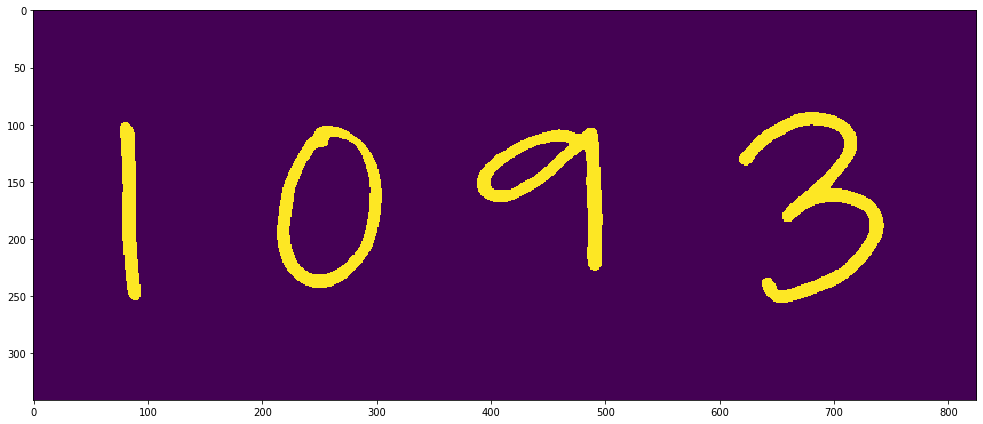

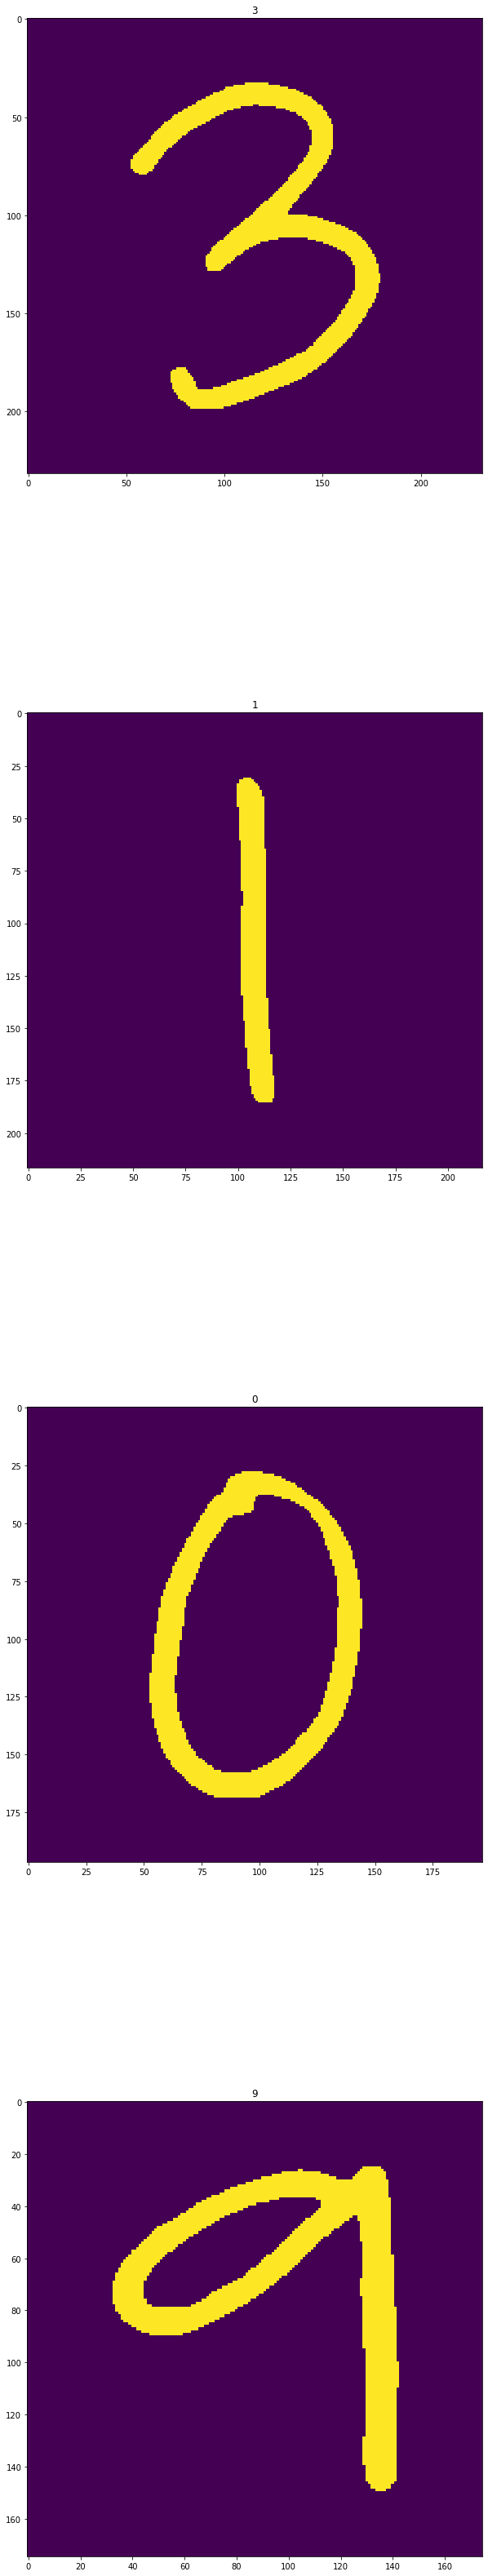

In [236]:
from math import ceil 
import cv2
from PIL import Image
IMAGE = "testset/1093.jpg"            ###imgs[0]
plt.imshow(io.imread(IMAGE))
binary_arr,label_arr, segments,orig = proc.label_segments(IMAGE,'',photo=True)
plt.imshow(np.array(binary_arr, dtype = np.uint8 ))

predictions = []
fig,axes = plt.subplots(len(segments),figsize=(10,60))
for seg,ax in list(zip(segments,axes.flatten())):
    found = label_arr==seg
    x,y = np.where(found)
    xmin,xmax,ymin,ymax = np.min(x),np.max(x),np.min(y),np.max(y)
    xlen,ylen = found[xmin:xmax,ymin:ymax].shape
    diff = np.abs(ylen-xlen)
    change = ceil(diff/2)
    if diff!=0:
        if ylen>xlen:
            xmin-=change
            xmax+=change

        else:
            ymin-=change
            ymax+=change

        xlen,ylen = xmax-xmin,ymax-ymin
        diff=np.abs(ylen-xlen)
        if xlen>ylen: ymax+=diff
        elif ylen>xlen: xmax+=diff
    digit = binary_arr[xmin:xmax,ymin:ymax]
    digit = np.pad(digit,int(len(digit)*.2),mode= 'constant', constant_values=(0,0))        
    

    if digit.shape[0]<10:
        ax.set_visible(False)       
        pass
    else:
        ax.imshow(digit)
        im = Image.fromarray(np.array(digit)*255.0).convert("RGB")
        im.save('000.png')
        img = cv2.resize(cv2.imread('000.png',cv2.IMREAD_GRAYSCALE),(28,28),interpolation=cv2.INTER_CUBIC)
        p = np.argmax(tf_model.predict(img.astype(float).flatten().reshape((1, 28, 28, 1))))
        ax.set_title(p)
        predictions.append([ymin,p])

predictions.sort()    
predictions = [pr[1] for pr in predictions]
print(IMAGE)
print(predictions)

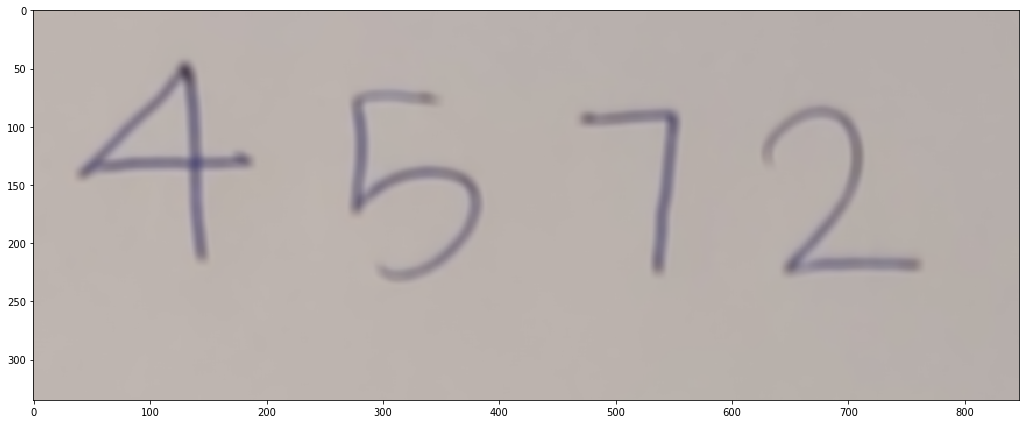

In [214]:
ORIG = io.imread(IMAGE)
GAUSS = cv2.blur(ORIG, (10, 10)) 
io.imshow(GAUSS)

In [98]:
results

array([1, 1, 1, 1], dtype=object)

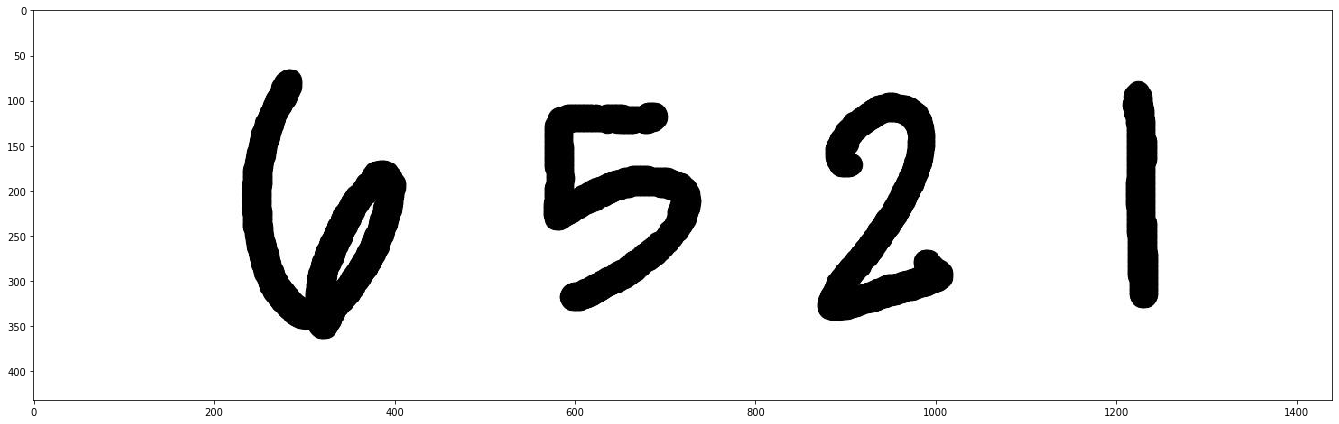

In [135]:
from skimage import io, filters, color
import cv2
BLACK = io.imread('_segmented.jpg')
INVERT = cv2.bitwise_not(BLACK)
io.imshow(INVERT)

In [ ]:
# plt.imshow(imgs[0])
print(imgs[0])
predictions

In [ ]:
df_subset['predict'] = predictions
df_subset

In [22]:
actual2 = []
predict2 = []

for i in range(len(df_subset)):
    actual2.append(np.array(df_subset)[i][1])
    predict2.append(list(df_subset.iloc[i]['predict'])    )


In [23]:
results = []
for i in range(len(df_subset)):
    results.append((np.array(actual2)[i]==np.array(predict2)[i])*1)
np.sum(np.sum(results))/(len(df_subset)*4)

/home/nina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0.86125

In [24]:
count_correct = []
for arr in results:
    count_correct.append(np.sum(arr))


In [25]:
all_correct = count_correct.count(4)
correct_3 = count_correct.count(3)
correct_2 = count_correct.count(2)
correct_1 = count_correct.count(1)
none_correct = count_correct.count(0)

In [26]:
print(all_correct,correct_3,correct_2,correct_1,none_correct)

583 312 82 13 10


In [27]:
print(all_correct,correct_3,correct_2,correct_1,none_correct)

583 312 82 13 10


In [31]:
N=len(results)/100

In [32]:
print(all_correct/N,correct_3/N,correct_2/N,correct_1/N,none_correct/N)

58.3 31.2 8.2 1.3 1.0


In [8]:
issues = [2,
 4,
 5,
 7,
 9,
 11,
 12,
 15,
 19,
 27,
 28,
 30,
 34,
 35,
 36,
 37,
 40,
 41,
 42,
 43,
 46,
 47,
 48,
 52,
 54,
 56,
 59,
 60,
 61,
 63,
 65,
 68,
 72,
 73,
 74,
 75,
 80,
 81,
 82,
 85,
 87,
 89,
 91,
 92,
 93,
 94,
 96,
 97,
 102,
 103,
 106,
 107,
 108,
 109,
 113,
 114,
 118,
 121,
 122,
 124,
 125,
 128,
 129,
 130,
 133,
 139,
 145,
 147,
 148,
 152,
 156,
 157,
 160,
 161,
 163,
 165,
 169,
 172,
 176,
 178,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 192,
 193,
 196,
 199,
 200,
 201,
 208,
 211,
 215,
 216,
 217,
 218,
 219,
 225,
 227,
 228,
 233,
 234,
 235,
 236,
 238,
 239,
 241,
 247,
 249,
 250,
 251,
 252,
 259,
 261,
 262,
 264,
 265,
 266,
 267,
 276,
 280,
 282,
 283,
 286,
 287,
 288,
 290,
 291,
 292,
 295,
 297,
 298,
 300,
 302,
 303,
 305,
 306,
 309,
 315,
 316,
 319,
 321,
 323,
 328,
 331,
 333,
 335,
 337,
 339,
 340,
 341,
 342,
 343,
 352,
 354,
 355,
 360,
 365,
 366,
 368,
 369,
 375,
 380,
 383,
 384,
 386,
 387,
 390,
 392,
 395,
 397,
 400,
 413,
 414,
 417,
 421,
 423,
 424,
 426,
 430,
 434,
 435,
 438,
 439,
 440,
 441,
 444,
 445,
 446,
 447,
 448,
 452,
 453,
 454,
 455,
 459,
 461,
 463,
 466,
 470,
 474,
 477,
 481,
 483,
 486,
 488,
 491,
 493,
 496,
 497,
 498,
 499,
 501,
 505,
 506,
 507,
 508,
 511,
 514,
 516,
 517,
 519,
 521,
 522,
 524,
 530,
 533,
 536,
 540,
 541,
 544,
 545,
 551,
 555,
 559,
 560,
 561,
 562,
 563,
 565,
 566,
 568,
 571,
 573,
 574,
 577,
 579,
 580,
 581,
 584,
 585,
 588,
 594,
 595,
 598,
 599,
 601,
 602,
 603,
 612,
 614,
 615,
 617,
 618,
 620,
 622,
 626,
 632,
 633,
 641,
 643,
 644,
 647,
 648,
 649,
 652,
 653,
 655,
 657,
 658,
 659,
 660,
 661,
 663,
 668,
 671,
 672,
 680,
 685,
 686,
 687,
 690,
 691,
 692,
 697,
 698,
 700,
 701,
 702,
 704,
 708,
 712,
 714,
 719,
 720,
 721,
 723,
 725,
 727,
 728,
 729,
 731,
 734,
 735,
 742,
 744,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 755,
 757,
 758,
 765,
 766,
 767,
 770,
 773,
 775,
 776,
 778,
 779,
 783,
 785,
 786,
 789,
 790,
 791,
 792,
 795,
 796,
 797,
 799,
 802,
 803,
 805,
 807,
 809,
 811,
 815,
 816,
 817,
 819,
 823,
 826,
 830,
 835,
 836,
 838,
 842,
 844,
 845,
 846,
 849,
 850,
 851,
 852,
 853,
 855,
 857,
 858,
 862,
 863,
 864,
 866,
 867,
 868,
 870,
 873,
 874,
 876,
 878,
 879,
 880,
 881,
 882,
 884,
 887,
 891,
 893,
 894,
 897,
 898,
 899,
 901,
 903,
 904,
 906,
 909,
 910,
 911,
 915,
 918,
 920,
 921,
 928,
 929,
 930,
 931,
 934,
 936,
 937,
 939,
 940,
 941,
 942,
 944,
 945,
 947,
 948,
 949,
 952,
 953,
 955,
 958,
 961,
 962,
 965,
 966,
 970,
 972,
 975,
 976,
 981,
 983,
 984,
 990,
 993,
 994,
 999,
 1000,
 1001,
 1003,
 1005,
 1006,
 1007,
 1008,
 1010,
 1013,
 1014,
 1016,
 1017,
 1018,
 1021,
 1022,
 1023,
 1024,
 1025,
 1030,
 1032,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047,
 1048,
 1050,
 1051,
 1053,
 1058,
 1059,
 1060,
 1062,
 1063,
 1066,
 1067,
 1072,
 1076,
 1078,
 1080,
 1081,
 1082,
 1085,
 1088,
 1090,
 1091,
 1092,
 1093,
 1094,
 1096,
 1097,
 1099,
 1100,
 1102,
 1104,
 1107,
 1108,
 1117,
 1118,
 1119,
 1120,
 1121,
 1124,
 1125,
 1126,
 1127,
 1128,
 1130,
 1134,
 1135,
 1140,
 1142,
 1146,
 1149,
 1151,
 1153,
 1156,
 1159,
 1161,
 1166,
 1167,
 1168,
 1170,
 1172,
 1173,
 1174,
 1176,
 1179,
 1182,
 1183,
 1186,
 1187,
 1189,
 1197,
 1198,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1211,
 1216,
 1220,
 1222,
 1225,
 1226,
 1227,
 1229,
 1230,
 1232,
 1234,
 1235,
 1236,
 1237,
 1238,
 1239,
 1246,
 1247,
 1249,
 1251,
 1255,
 1256,
 1258,
 1262,
 1264,
 1266,
 1267,
 1268,
 1269,
 1271,
 1273,
 1274,
 1276,
 1278,
 1281,
 1282,
 1285,
 1286,
 1289,
 1290,
 1293,
 1300,
 1301,
 1302,
 1303,
 1307,
 1308,
 1309,
 1310,
 1311,
 1314,
 1315,
 1316,
 1317,
 1318,
 1320,
 1322,
 1323,
 1326,
 1327,
 1329,
 1330,
 1334,
 1335,
 1345,
 1346,
 1347,
 1348,
 1349,
 1351,
 1356,
 1357,
 1358,
 1359,
 1360,
 1361,
 1364,
 1365,
 1366,
 1367,
 1372,
 1373,
 1375,
 1376,
 1377,
 1378,
 1381,
 1383,
 1384,
 1385,
 1386,
 1391,
 1397,
 1398,
 1399,
 1402,
 1405,
 1408,
 1409,
 1413,
 1414,
 1416,
 1417,
 1418,
 1419,
 1421,
 1422,
 1425,
 1426,
 1427,
 1428,
 1429,
 1430,
 1432,
 1434,
 1437,
 1440,
 1443,
 1445,
 1450,
 1452,
 1454,
 1455,
 1456,
 1461,
 1462,
 1463,
 1466,
 1468,
 1469,
 1470,
 1472,
 1473,
 1476,
 1481,
 1482,
 1483,
 1488,
 1489,
 1490,
 1491,
 1493]


In [21]:
import tensorflow as tf